# Continuous Control

This is the report for the Continuous Control lab on the Udacity DRLND. It trains an agent using a DDPG model.

## 1. Install and Start the Environment

In [ ]:
!pip install unityagents

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## Train the Model

The agent is a ddpg agent taken from ddpg2.py. The actor network is a 3 layer fully connected model with batch normalization and the critic is also a 3 layer fully connected model with batch normalization. More complex models has very poor performance, overparameterization likely causing early instability. It uses an agent modified from an example project in the class, with a much larger buffer size, removed noise, and adjusted model structures. The reward is also multiplied by 0.1 to stablize the mse error signal. I'm not sure why but the environment fit much slower than the walkthrough. As suggested the model fits 10 times every 20 steps. The model converges to the solution after ~340 episodes and stays at this level for 100 steps before training terminated.

The algorithm does not rely on any additional noise parameter, it uses the randomality contained in the initialization of the model parameters. The weights are updated with a ddpg pattern, modelling Q learning but instead of generating a value for every possible action, simply produces a gradient to update the on policy action by propogating the gradient maximizing the expected future reward from a separate critic network. The model keeps a replay buffer to store past experiences, as the algorithm is capable of off-policy learning. In this case the replay buffer is of size 1000000, and does not implement prioritized replay as it demonstrated a negative effect on convergence. The ddpg algorithm works by having 2 networks, an actor and critic network (plus 2 target networks that get soft updated periodically), the actor mapping a state onto a continuous action, and the critic mapping a state action pair onto a Q value. The agent then collects experiences from acting in the environment using the policy defined by the actor and possibly some noise, then the actor and critic networks are updated in batch using a replay buffer, the critic being updated by mapping a state action pair onto the target network's value of the next state and next state's best action pair. The actor then updates its policy from the gradient maximizing the critic's estimated value of its generated action for that state. While not critical, the replay buffer allows the previous experiences to be preserved and learned from, leading to more stable learning and higher sample efficiency. A noise process might be useful in some cases where the agent cannot explore the entire environment with the initialization parameters, especially since the policy is deterministic.

In [3]:
from ddpg2 import Agent
from collections import deque
import torch
from torch import optim
from time import time

gamma = .99
n_episodes = 2000
max_t = 10000
agent = Agent(state_size, action_size, buffer_size=int(1e6), batch_size=128, lra=0.0002, lrc=0.0002)

# keep track of progress    
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100) 
adj_scores_window = deque(maxlen=10)
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations               # get the current state
    score = np.zeros(len(state), dtype=float)
    adj_score = np.zeros(len(state), dtype=float)
    agent.reset()
    for t in range(max_t):
        action = agent.act(state, False)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations      # get the next state
        reward = env_info.rewards                    # get the reward
        adj_reward = reward# + np.mean(np.power(action, 2), 1) * torque_reward 
        done = env_info.local_done                     # see if episode has finished
        agent.step(state, action, adj_reward, next_state, done)
        if t % 20 == 0:
            for _ in range(10):
                agent.learn(gamma)
        state = next_state
        score += reward
        adj_score += adj_reward
        if any(done):
            break 
    scores_window.append(np.mean(score))       # save most recent score
    adj_scores_window.append(np.mean(adj_score))
    scores.append(score)              # save most recent score
    print('\rEpisode {}\tAverage Score: {:.2f} ({:.2f})'.format(i_episode, np.mean(scores_window), np.mean(adj_scores_window)), end="")
    if i_episode % 10 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} ({:.2f})'.format(i_episode, np.mean(scores_window), np.mean(adj_scores_window)))
    if np.mean(scores_window) > 30:
        print('\nEnvironment fit in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint.pth')
        break

torch.save(agent.actor_local.state_dict(), 'checkpoint.pth')

Episode 10	Average Score: 0.64 (0.64)
Episode 20	Average Score: 1.03 (1.42)
Episode 30	Average Score: 1.07 (1.15)
Episode 40	Average Score: 1.21 (1.62)
Episode 50	Average Score: 1.28 (1.57)
Episode 60	Average Score: 1.41 (2.05)
Episode 70	Average Score: 1.49 (1.99)
Episode 80	Average Score: 1.56 (2.01)
Episode 90	Average Score: 1.65 (2.35)
Episode 100	Average Score: 1.71 (2.30)
Episode 110	Average Score: 1.79 (1.40)
Episode 120	Average Score: 1.76 (1.13)
Episode 130	Average Score: 1.79 (1.44)
Episode 140	Average Score: 1.84 (2.14)
Episode 150	Average Score: 1.93 (2.48)
Episode 160	Average Score: 2.04 (3.15)
Episode 170	Average Score: 2.19 (3.49)
Episode 180	Average Score: 2.37 (3.81)
Episode 190	Average Score: 2.56 (4.27)
Episode 200	Average Score: 2.73 (3.99)
Episode 210	Average Score: 3.03 (4.35)
Episode 220	Average Score: 3.41 (4.93)
Episode 230	Average Score: 3.83 (5.65)
Episode 240	Average Score: 4.29 (6.74)
Episode 250	Average Score: 4.83 (7.94)
Episode 260	Average Score: 5.33 (8

AttributeError: 'Agent' object has no attribute 'qnetwork_local'

In [5]:
torch.save(agent.actor_local.state_dict(), 'checkpoint.pth')

In [ ]:
!pip install matplotlib

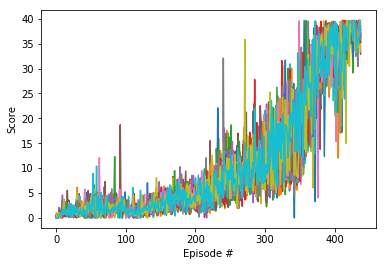

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.ion()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Result

The agent was tested and acheived an average score of 38.77

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.77549913330004


## Future Improvements

Potential improvements include adding a prioritized replay buffer, adding stochastisity to the models for capturing uncertainty, using random network distilation to improve its early exploration, and adding shared weights for featurization of the state. A further exploration through model architectures and hyperparameters may be necessary as the performance of this model doesn't seem to be similar to the benchmark.